# Installations

In [ ]:
#!apt-get update
#!apt-get install cuda-10.1
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
#!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-ornrufsj
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-ornrufsj
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 0a71d56e5dce3ff1f0dd2c47c29367629262f527
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4295 sha256=52d4e5ea7d096ccacadfaf25ae832ba318a68cb5f038575ac2e2d8cae50af44e
  Stored in directory: /tmp/pip-ephem-wheel-cache-lw80do_y/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built NVCCPlugin
created output directory at /content/cuda-samples/Samples/1_Utilities/deviceQuery/src
Out bin /content/cuda-samples/Samples/1_Utilities/deviceQuery/result.out


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!git clone https://github.com/NVIDIA/cuda-samples.git
%cd /content/cuda-samples/Samples/1_Utilities/deviceQuery
!make
!ls
!./deviceQuery

Cloning into 'cuda-samples'...
remote: Enumerating objects: 16041, done.
remote: Counting objects: 100% (3455/3455), done.
remote: Compressing objects: 100% (431/431), done.
remote: Total 16041 (delta 3129), reused 3280 (delta 3022), pack-reused 12586
Receiving objects: 100% (16041/16041), 133.28 MiB | 11.67 MiB/s, done.
Resolving deltas: 100% (13585/13585), done.
Updating files: 100% (3981/3981), done.
/content/cuda-samples/Samples/1_Utilities/deviceQuery
make: Nothing to be done for 'all'.
cuda-samples		    deviceQuery_vs2022.sln
deviceQuery		    deviceQuery_vs2022.vcxproj
deviceQuery.cpp		    Makefile
deviceQuery.o		    NsightEclipse.xml
deviceQuery_vs2017.sln	    README.md
deviceQuery_vs2017.vcxproj  src
deviceQuery_vs2019.sln	    Zhazira_Kabdrakhmetova_LA4
deviceQuery_vs2019.vcxproj  Zhazira_Kabdrakhmetova_LA4.cu
./deviceQuery Starting...

 CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "Tesla T4"
  CUDA Driver Version

# Lab 4 Code


In [ ]:
lab4 = """
// Zhazira Kabdrakhmetova || ID: 201980168
// Course: CSCI325 Fall23 || LA4

#define M 512
#define P 256
#define N 128

// Block Size choices for 4 configurations: from 2 to 32
// choosing anything beyond 32x32 would be bad
// because threads per block limitation is 1024
// thus starting from (2x2) to (32x32) were chosen
// More analysis below the code

#define BLOCK_SIZE_0 16
#define BLOCK_SIZE_1 4
#define BLOCK_SIZE_2 8
#define BLOCK_SIZE_3 32
#define BLOCK_SIZE_4 2
#define BLOCK_SIZE_5 1

#include <stdio.h>
#include <time.h>

void mmSequential(float A[M][P], float B[P][N], float C[M][N]) {
    for (int i=0; i<M; i++){
        for (int j=0; j<N; j++){
            C[i][j] = 0;
            for (int k=0; k<P; k++){
                C[i][j] += A[i][k] * B[k][j]; // +2 global reads +1 global write
            }
        }
    }
}

 __global__ void mmGlobal(float A[M][P], float B[P][N], float C[M][N]) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;
    float temp_val = 0.0f;

    // check for index out of bounds
    if (row < M && col < N) {
        for (int k = 0; k < P; k++) {
            // dot product sum by all k in two matrices
            temp_val += A[row][k] * B[k][col]; // +2 global reads
        }
        C[row][col] = temp_val; // +1 global write
    }
}

__global__ void mmShared(float A[M][P], float B[P][N], float C[M][N]) {
    // sharing A and B matrices so that they can be read simultaneously
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;
    float temp_val = 0.0f;

    // tiling of block size (16,16) in this config
    __shared__ float As[BLOCK_SIZE_0][BLOCK_SIZE_0];
    __shared__ float Bs[BLOCK_SIZE_0][BLOCK_SIZE_0];

    // outer loop: tiling by dividing into subblocks
    for (int k = 0; k < P / BLOCK_SIZE_0; k++) {
        int temp_index = k * BLOCK_SIZE_0 + threadIdx.x;
        As[threadIdx.y][threadIdx.x] = A[row][temp_index]; // +1 global read
        Bs[threadIdx.y][threadIdx.x] = B[temp_index][col]; // +1 global read
        __syncthreads();

        //inner loop: dot product inside of a single block
        for (int e = 0; e < BLOCK_SIZE_0; e++) {
            temp_val += As[threadIdx.y][e] * Bs[e][threadIdx.x];
        }
        __syncthreads();
    }
    if (row < M && col < N) {
          C[row][col] = temp_val; // +1 global write
    }
}

__global__ void mmShared1(float A[M][P], float B[P][N], float C[M][N]) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;
    float temp_val = 0.0f;

    __shared__ float As[BLOCK_SIZE_1][BLOCK_SIZE_1];
    __shared__ float Bs[BLOCK_SIZE_1][BLOCK_SIZE_1];

    for (int k = 0; k < P / BLOCK_SIZE_1; k++) {
        int temp_index = k * BLOCK_SIZE_1 + threadIdx.x;
        As[threadIdx.y][threadIdx.x] = A[row][temp_index];
        Bs[threadIdx.y][threadIdx.x] = B[temp_index][col];
        __syncthreads();

        for (int e = 0; e < BLOCK_SIZE_1; e++) {
            temp_val += As[threadIdx.y][e] * Bs[e][threadIdx.x];
        }
        __syncthreads();
    }
    if (row < M && col < N) {
        C[row][col] = temp_val;
    }
}

__global__ void mmShared2(float A[M][P], float B[P][N], float C[M][N]) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;
    float temp_val = 0.0f;

    __shared__ float As[BLOCK_SIZE_2][BLOCK_SIZE_2];
    __shared__ float Bs[BLOCK_SIZE_2][BLOCK_SIZE_2];

    for (int k = 0; k < P / BLOCK_SIZE_2; k++) {
        int temp_index = k * BLOCK_SIZE_2 + threadIdx.x;
        As[threadIdx.y][threadIdx.x] = A[row][temp_index];
        Bs[threadIdx.y][threadIdx.x] = B[temp_index][col];
        __syncthreads();

        for (int e = 0; e < BLOCK_SIZE_2; e++) {
            temp_val += As[threadIdx.y][e] * Bs[e][threadIdx.x];
        }
        __syncthreads();
    }
    if (row < M && col < N) {
        C[row][col] = temp_val;
    }
}

__global__ void mmShared3(float A[M][P], float B[P][N], float C[M][N]) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;
    float temp_val = 0.0f;

    __shared__ float As[BLOCK_SIZE_3][BLOCK_SIZE_3];
    __shared__ float Bs[BLOCK_SIZE_3][BLOCK_SIZE_3];

    for (int k = 0; k < P / BLOCK_SIZE_3; k++) {
        int temp_index = k * BLOCK_SIZE_3 + threadIdx.x;
        As[threadIdx.y][threadIdx.x] = A[row][temp_index];
        Bs[threadIdx.y][threadIdx.x] = B[temp_index][col];
        __syncthreads();

        for (int e = 0; e < BLOCK_SIZE_3; e++) {
            temp_val += As[threadIdx.y][e] * Bs[e][threadIdx.x];
        }
        __syncthreads();
    }
    if (row < M && col < N) {
        C[row][col] = temp_val;
    }
}

__global__ void mmShared4(float A[M][P], float B[P][N], float C[M][N]) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;
    float temp_val = 0.0f;

    __shared__ float As[BLOCK_SIZE_4][BLOCK_SIZE_4];
    __shared__ float Bs[BLOCK_SIZE_4][BLOCK_SIZE_4];

    for (int k = 0; k < P / BLOCK_SIZE_4; k++) {
        int temp_index = k * BLOCK_SIZE_4 + threadIdx.x;
        As[threadIdx.y][threadIdx.x] = A[row][temp_index];
        Bs[threadIdx.y][threadIdx.x] = B[temp_index][col];
        __syncthreads();

        for (int e = 0; e < BLOCK_SIZE_4; e++) {
            temp_val += As[threadIdx.y][e] * Bs[e][threadIdx.x];
        }
        __syncthreads();
    }
    if (row < M && col < N) {
        C[row][col] = temp_val;
    }
}

__global__ void mmShared5(float A[M][P], float B[P][N], float C[M][N]) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    int col = blockIdx.y * blockDim.y + threadIdx.y;
    float temp_val = 0.0f;

    __shared__ float As[BLOCK_SIZE_5][BLOCK_SIZE_5];
    __shared__ float Bs[BLOCK_SIZE_5][BLOCK_SIZE_5];

    for (int k = 0; k < P / BLOCK_SIZE_5; k++) {
        int temp_index = k * BLOCK_SIZE_5 + threadIdx.x;
        As[threadIdx.y][threadIdx.x] = A[row][temp_index];
        Bs[threadIdx.y][threadIdx.x] = B[temp_index][col];
        __syncthreads();

        for (int e = 0; e < BLOCK_SIZE_5; e++) {
            temp_val += As[threadIdx.y][e] * Bs[e][threadIdx.x];
        }
        __syncthreads();
    }
    if (row < M && col < N) {
        C[row][col] = temp_val;
    }
}


void verifyArr(float C[M][N], float val) {
    float max_error = 0.0f;
    float temp_error = 0.0f;
    for (int i=0; i<M; i++){
        for (int j=0; j<N; j++){
            // take only positive value of the difference
            if (C[i][j] > val) {
                temp_error = C[i][j] - val;
            } else if (C[i][j] < val) {
                temp_error = val - C[i][j];
            } else {
                continue;
            }
            // update max error accordingly
            if (temp_error > max_error) {
                max_error = temp_error;
                printf("%f at index %d %d \\n", C[i][j], i, j);
            }
        }
    }
    printf("max error was %f\\n", max_error);
}


int main(){
    // 0: INITIALIZATION
    clock_t start_time, end_time;
    float A[M][P], B[P][N], C[M][N];

    for (int i=0; i<M; i++){
        for (int j=0; j<P; j++){
            A[i][j]=1.0f;
        }
    }
    for (int j=0; j<P; j++){
        for (int k=0; k<N; k++){
            B[j][k]=2.0f;
        }
    }

    float (*deviceA)[P], (*deviceB)[N], (*deviceC)[N];
    cudaMalloc((void **)&deviceA, (M*P) * sizeof(float));
    cudaMalloc((void **)&deviceB, (P*N) * sizeof(float));
    cudaMalloc((void **)&deviceC, (M*N) * sizeof(float));


    // 1ST: SEQUENTIAL
    start_time = clock();
    mmSequential(A, B, C);
    end_time = clock();
    double elapsed_time = ((double)(end_time - start_time)) / CLOCKS_PER_SEC;
    printf("Elapsed time for config 1: %f ms (SEQUENTIAL C)\\n", elapsed_time * 1000);
    verifyArr(C, 512.0);

    // reinitialize C array
    for (int i=0; i<M; i++){
        for (int k=0; k<N; k++){
            C[i][k]=0.0f;
        }
    }

    // 2ND: GLOBAL MEMORY
    dim3 threadPerBlocks(16,16);
    dim3 numBlocks((M + threadPerBlocks.x - 1) / threadPerBlocks.x, (N + threadPerBlocks.y - 1) / threadPerBlocks.y);

    cudaMemcpy(deviceA, A, (M*P) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, B, (P*N) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceC, C, (M*N) * sizeof(float), cudaMemcpyHostToDevice);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    mmGlobal<<<numBlocks, threadPerBlocks>>>(deviceA, deviceB, deviceC);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    float ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Elapsed time for config 2: %f ms (GLOBAL MEMORY)\\n", ms);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaMemcpy(C, deviceC, (M*N) * sizeof(float), cudaMemcpyDeviceToHost);
    verifyArr(C, 512.0);

    // reinitialize C array
    for (int i=0; i<M; i++){
        for (int k=0; k<N; k++){
            C[i][k]=0.0f;
        }
    }

    // 3RD: SHARED MEMORY
    cudaMemcpy(deviceA, A, (M*P) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, B, (P*N) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceC, C, (M*N) * sizeof(float), cudaMemcpyHostToDevice);

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    mmShared<<<numBlocks, threadPerBlocks>>>(deviceA, deviceB, deviceC);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Elapsed time for config 3: %f ms (SHARED MEMORY 16,16)\\n", ms);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaMemcpy(C, deviceC, (M*N) * sizeof(float), cudaMemcpyDeviceToHost);
    verifyArr(C, 512.0);

    // reinitialize C array
    for (int i=0; i<M; i++){
        for (int k=0; k<N; k++){
            C[i][k]=0.0f;
        }
    }


    // 4TH: SHARED MEMORY 1 - threads per block (4,4)
    dim3 threadPerBlocks1(4,4);
    dim3 numBlocks1((M + threadPerBlocks1.x - 1) / threadPerBlocks1.x, (N + threadPerBlocks1.y - 1) / threadPerBlocks1.y);

    cudaMemcpy(deviceA, A, (M*P) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, B, (P*N) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceC, C, (M*N) * sizeof(float), cudaMemcpyHostToDevice);

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    mmShared1<<<numBlocks1, threadPerBlocks1>>>(deviceA, deviceB, deviceC);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Elapsed time for config 4: %f ms (SHARED MEMORY 4,4)\\n", ms);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaMemcpy(C, deviceC, (M*N) * sizeof(float), cudaMemcpyDeviceToHost);
    verifyArr(C, 512.0);

    // reinitialize C array
    for (int i=0; i<M; i++){
        for (int k=0; k<N; k++){
            C[i][k]=0.0f;
        }
    }


    // 5TH: SHARED MEMORY 2 - threads per block (8,8)
    dim3 threadPerBlocks2(8,8);
    dim3 numBlocks2((M + threadPerBlocks2.x - 1) / threadPerBlocks2.x, (N + threadPerBlocks2.y - 1) / threadPerBlocks2.y);

    cudaMemcpy(deviceA, A, (M*P) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, B, (P*N) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceC, C, (M*N) * sizeof(float), cudaMemcpyHostToDevice);

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    mmShared2<<<numBlocks2, threadPerBlocks2>>>(deviceA, deviceB, deviceC);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Elapsed time for config 5: %f ms (SHARED MEMORY 8,8)\\n", ms);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaMemcpy(C, deviceC, (M*N) * sizeof(float), cudaMemcpyDeviceToHost);
    verifyArr(C, 512.0);

    // reinitialize C array
    for (int i=0; i<M; i++){
        for (int k=0; k<N; k++){
            C[i][k]=0.0f;
        }
    }


    // 6TH: SHARED MEMORY 3 - threads per block (32,32)
    dim3 threadPerBlocks3(32,32);
    dim3 numBlocks3((M + threadPerBlocks3.x - 1) / threadPerBlocks3.x, (N + threadPerBlocks3.y - 1) / threadPerBlocks3.y);

    cudaMemcpy(deviceA, A, (M*P) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, B, (P*N) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceC, C, (M*N) * sizeof(float), cudaMemcpyHostToDevice);

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    mmShared3<<<numBlocks3, threadPerBlocks3>>>(deviceA, deviceB, deviceC);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Elapsed time for config 6: %f ms (SHARED MEMORY 32,32)\\n", ms);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaMemcpy(C, deviceC, (M*N) * sizeof(float), cudaMemcpyDeviceToHost);
    verifyArr(C, 512.0);

    // reinitialize C array
    for (int i=0; i<M; i++){
        for (int k=0; k<N; k++){
            C[i][k]=0.0f;
        }
    }


    // 7TH: SHARED MEMORY 4 - threads per block (2,2)
    dim3 threadPerBlocks4(2,2);
    dim3 numBlocks4((M + threadPerBlocks4.x - 1) / threadPerBlocks4.x, (N + threadPerBlocks4.y - 1) / threadPerBlocks4.y);

    cudaMemcpy(deviceA, A, (M*P) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, B, (P*N) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceC, C, (M*N) * sizeof(float), cudaMemcpyHostToDevice);

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    mmShared4<<<numBlocks4, threadPerBlocks4>>>(deviceA, deviceB, deviceC);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Elapsed time for config 7: %f ms (SHARED MEMORY 2,2)\\n", ms);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaMemcpy(C, deviceC, (M*N) * sizeof(float), cudaMemcpyDeviceToHost);
    verifyArr(C, 512.0);

    // reinitialize C array
    for (int i=0; i<M; i++){
        for (int k=0; k<N; k++){
            C[i][k]=0.0f;
        }
    }


    // 8TH: SHARED MEMORY 5 - threads per block (1,1)
    dim3 threadPerBlocks5(1,1);
    dim3 numBlocks5((M + threadPerBlocks5.x - 1) / threadPerBlocks5.x, (N + threadPerBlocks5.y - 1) / threadPerBlocks5.y);

    cudaMemcpy(deviceA, A, (M*P) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceB, B, (P*N) * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(deviceC, C, (M*N) * sizeof(float), cudaMemcpyHostToDevice);

    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    mmShared5<<<numBlocks5, threadPerBlocks5>>>(deviceA, deviceB, deviceC);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);
    ms = 0;
    cudaEventElapsedTime(&ms, start, stop);
    printf("Elapsed time for config 8: %f ms (SHARED MEMORY 1,1)\\n", ms);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    cudaMemcpy(C, deviceC, (M*N) * sizeof(float), cudaMemcpyDeviceToHost);
    verifyArr(C, 512.0);


    cudaFree(deviceA);
    cudaFree(deviceB);
    cudaFree(deviceC);

    return 0;
}

"""

In [ ]:
text_file = open("Zhazira_Kabdrakhmetova_LA4.cu", "w")
text_file.write(lab4)
text_file.close()
!nvcc -o Zhazira_Kabdrakhmetova_LA4 Zhazira_Kabdrakhmetova_LA4.cu -Xcompiler -fopenmp -lgomp
!./Zhazira_Kabdrakhmetova_LA4

Elapsed time for config 1: 115.025000 ms (SEQUENTIAL C)
max error was 0.000000
Elapsed time for config 2: 0.855776 ms (GLOBAL MEMORY)
max error was 0.000000
Elapsed time for config 3: 0.159520 ms (SHARED MEMORY 16,16)
max error was 0.000000
Elapsed time for config 4: 0.430336 ms (SHARED MEMORY 4,4)
max error was 0.000000
Elapsed time for config 5: 0.176000 ms (SHARED MEMORY 8,8)
max error was 0.000000
Elapsed time for config 6: 0.193024 ms (SHARED MEMORY 32,32)
max error was 0.000000
Elapsed time for config 7: 2.553760 ms (SHARED MEMORY 2,2)
max error was 0.000000
Elapsed time for config 8: 17.287041 ms (SHARED MEMORY 1,1)
max error was 0.000000


#Analysis with Device Query results

In [ ]:
# Device 0: "Tesla T4"
#   Total amount of global memory:                 15102 MBytes (15835398144 bytes)
#   (040) Multiprocessors, (064) CUDA Cores/MP:    2560 CUDA Cores
#   GPU Max Clock rate:                            1590 MHz (1.59 GHz)
#   Memory Clock rate:                             5001 Mhz
#   Memory Bus Width:                              256-bit
#   L2 Cache Size:                                 4194304 bytes

In [ ]:
#   CONCLUSIONS:
#   You can also see Graphs comparing different configurations in the below code

#   SEQUENTIAL C:
#   This is an inefficien configuration with expectedly slowest execution time
#   not utilizing thread/memory parallelization in matrix mult yields bad result
#   There are three loops with complexity O(M*P*N) which simplifies to O(n^3)
#   BWe = (2 reads + 1 write)*M*N*P*4(bytes)/10^9/exec_time
#   which results in the largest exec time and lowest Bandwidth efficiency

#   GLOBAL MEMORY:
#   although it utilizes thread parallelization, it doesn't use shared memory
#   this results in a slower execution compared to some shared mem configs
#   in memory hierarchy sorted by speed Registers > Shared Mem > Global Mem
#   BWe = (2 reads * P + 1 write)*M*N/10^9/exec_time
#   because it is off-chip memory there is latency in access time
#   but because of thread parallelism it is not as slow as sequenctial C

#   SHARED MEMORY:
#   shared memory utilizes a quicker type of memory, and threads in same block
#   can share the same data and communicate with each other efficiently
#   BWe = (2 reads * P/BLOCK_SIZE + 1 write * BLOCK_SIZE)*4*M*N/10^9/exec_time
#   however its efficiency changes with Block Size

#   SHARED MEMORY (A): slower than global memory
#   in cases 1x1 and 2x2 their exec times are slower than global memory
#   some reasons for this slow down are:
#     (1) overhead when creating a CUDA kernel - because small block size
#         increases the number of blocks respectively, there are too many blocks
#         each time we have to create a new block it creates an overhead
#     (2) inefficient memory accesses - we create small number of threads,
#         so due to this shared memory blocks may not be fully utilized,
#         which is why GPU and memory access efficiency is decreased

#   SHARED MEMORY (B): faster than global memory
#   in cases like 4x4, 8x8, 16x16, 32x32 we can see bigger bandwidth efficiency
#   and quicker execution time. Here we see efficient use of memory parallelism.
#   By using tiling approach we use a Divide and Conquer approach for efficieny.
#   Instead of running 3 loops like in Sequential C we utilize both:
#     (1) THREAD PARALLELISM - tasks are divided to several threads running
#                              in parallel, so each of them is working on a part
#                              of matrix multiplication.
#     (2) MEMORY PARALLELISM - tasks have separate shared memory which can be
#                              accessed by threads in the same block. Memory
#                              accesses to shared are quicker than to global mem

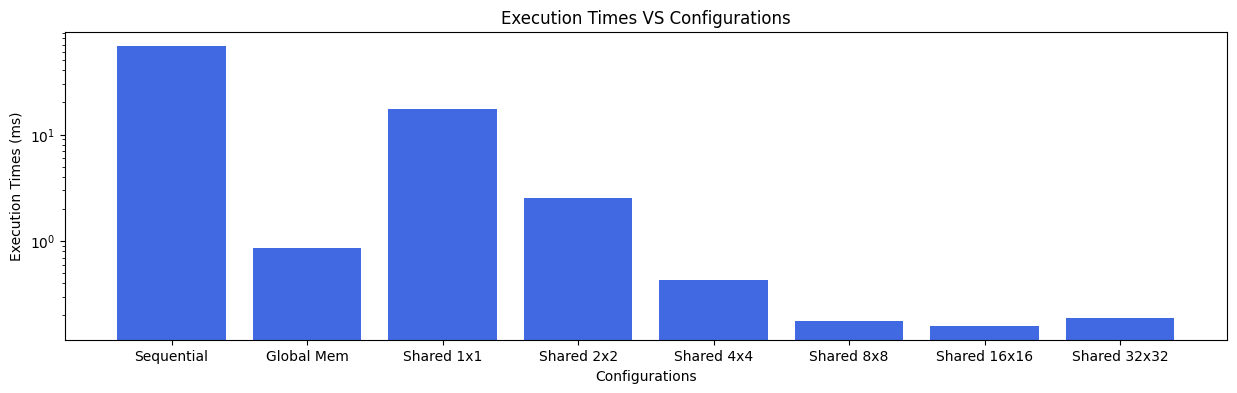

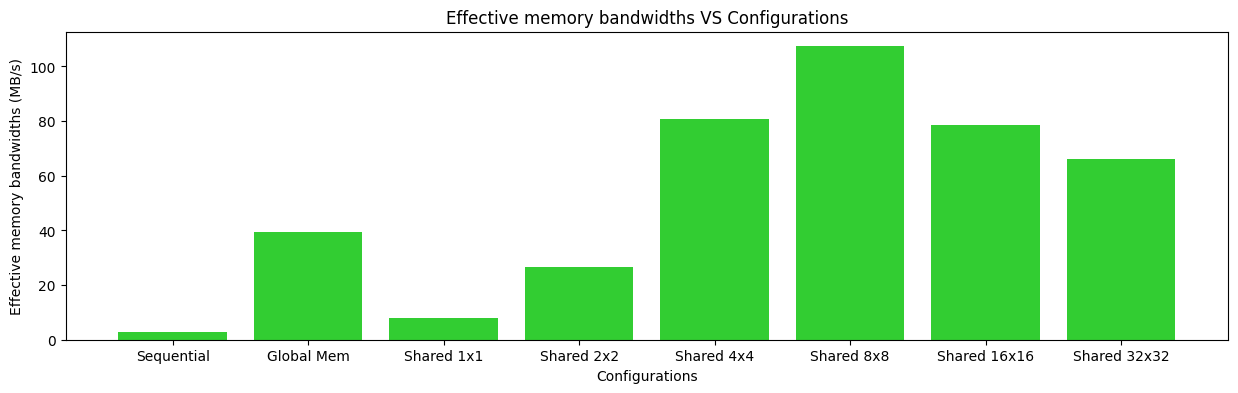

In [ ]:
import matplotlib.pyplot as plt

M=512
P=256
N=128

# these were example exec times taken from when I was executing the code
configs = ["Sequential", "Global Mem", "Shared 1x1", "Shared 2x2", "Shared 4x4", "Shared 8x8", "Shared 16x16", "Shared 32x32"]
exec_times = [68.229000, 0.853344, 17.287777, 2.548992, 0.429312, 0.175872, 0.160192, 0.190176]
BWes = [3*M*N*P*4/1000000/exec_times[0],
        (2*P+1)*M*N/1000000/exec_times[1],
        (2*P/1+1*1)*4*M*N/1000000/exec_times[2],
        (2*P/2+1*2)*4*M*N/1000000/exec_times[3],
        (2*P/4+1*4)*4*M*N/1000000/exec_times[4],
        (2*P/8+1*8)*4*M*N/1000000/exec_times[5],
        (2*P/16+1*16)*4*M*N/1000000/exec_times[6],
        (2*P/32+1*32)*4*M*N/1000000/exec_times[7]
        ]

plt.figure(figsize=(15, 4))
plt.bar(configs, exec_times, color='royalblue')
plt.xlabel('Configurations')
plt.ylabel('Execution Times (ms)')
plt.title('Execution Times VS Configurations')
plt.yscale('log')
plt.show()

plt.figure(figsize=(15, 4))
plt.bar(configs, BWes, color='limegreen')
plt.xlabel('Configurations')
plt.ylabel('Effective memory bandwidths (MB/s)')
plt.title('Effective memory bandwidths VS Configurations')
plt.show()